## **Aplicação de Regressão Linear Múltipla**
Neste notebook será aplicado o modelo de regressão múltipla, bem como a construção de features para captura de sazonalidade e outras características das séries temporais.
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos baseline **SARIMA** e **ETS**. 

In [1]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import swifter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from feature_engine.creation import CyclicalFeatures 
from src.outliers import detect_outliers
from src.features import add_calendar_features
from src.features import add_lagged_features
from src.features import lasso_feature_selection
from src.evaluation import Evaluation
from src.plots import plot_metrics
from src.plots import plot_time_series

# configurando notebook
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# configuração de estilo
sns.set_theme(context='paper')
plt.rcParams["figure.dpi"] = 150


%load_ext autoreload
%autoreload 2

EVAL_PATH = 'data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("data/test_df.csv", parse_dates=['ds'])

## **Engenharia de Características**
Acrescentaremos algumas features para tentar captar a sazonalidade treinando um modelo de regressão linear múltipla.
Algums preditores são sugeridos em [Forecasting: Principles and Practice (3rd ed) - Useful Predictors](https://otexts.com/fpp3/useful-predictors.html).

In [3]:
# inserindo as features nos dados de treino e teste
features_train_df = (
    train_df
    .groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
    .reset_index(drop=True)
)

features_test_df = (
    test_df
    .groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
    .reset_index(drop=True)
)

# outliers
features_train_df = detect_outliers(features_train_df)
features_test_df.loc[:, ['max_outliers', 'min_outliers']] = 0

Agora, para algumas features já criadas, serão adicionados atrasos ou adiantamentos (lags). O propósito é modelar o efeito de alguns eventos nos dias anteriores ou posteriores aos seus acontecimentos. Por exemplo: o feriado do dia 25dez tem efeito na variável não apenas no próprio dia, mas em dias anteriores ou posteriores. \
A função `add_lagged_features` desenvolvida adiciona atrasos às features de um dataframe.

In [4]:
features_test_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'max_outliers', 'min_outliers'],
      dtype='object')

In [5]:
# inserindo os lags nos dados de treino e teste

kwargs = {
    'features' : ['feriado', 'month_end'],
    'lags' : [-3, -2, -1, 1, 2, 3]
}

features_train_df = (
    features_train_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

features_test_df = (
    features_test_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

In [6]:
features_test_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'max_outliers', 'min_outliers',
       'feriado_lag-3', 'feriado_lag-2', 'feriado_lag-1', 'feriado_lag1',
       'feriado_lag2', 'feriado_lag3', 'month_end_lag-3', 'month_end_lag-2',
       'month_end_lag-1', 'month_end_lag1', 'month_end_lag2',
       'month_end_lag3'],
      dtype='object')

In [7]:
features_to_encode = [
    "day",
    "week",
    "day_of_week",
    "month",
    "quarter",
]
max_values = {
    "day" : 31,
    "week" : 53,
    "day_of_week" : 6,
    "month" : 12,
    "quarter" : 4,
}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)

features_train_df = cyclical_encoder.fit_transform(features_train_df)
features_test_df = cyclical_encoder.fit_transform(features_test_df)


In [8]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'max_outliers', 'min_outliers',
       'feriado_lag-3', 'feriado_lag-2', 'feriado_lag-1', 'feriado_lag1',
       'feriado_lag2', 'feriado_lag3', 'month_end_lag-3', 'month_end_lag-2',
       'month_end_lag-1', 'month_end_lag1', 'month_end_lag2', 'month_end_lag3',
       'day_sin', 'day_cos', 'week_sin', 'week_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'quarter_sin',
       'quarter_cos'],
      dtype='object')

Para realizar regressão linear múltipla com dados com variáveis categóricas de calendário, convém transformá-las em variáveis dummy, conforme sugerido em [Forecasting: Principles and Practice (3rd ed) - Seasonal dummy variables](https://otexts.com/fpp3/useful-predictors.html#seasonal-dummy-variables).

In [9]:
categories = ['day', 'day_of_week', 'week', 'month', 'quarter']

encoder = OneHotEncoder(drop='first')
encoder.fit(features_train_df[categories])


# aplicando nos dados de treino
X_train_encoded = pd.DataFrame(
    data = encoder.transform(features_train_df[categories]).toarray(), 
    columns=encoder.get_feature_names_out()
)

encoded_train_df = pd.concat(
    [features_train_df.drop(columns=categories), X_train_encoded], 
    axis=1
)


# aplicando nos dados de teste
X_test_encoded = pd.DataFrame(
    data = encoder.transform(features_test_df[categories]).toarray(), 
    columns=encoder.get_feature_names_out()
)

encoded_test_df = pd.concat(
    [features_test_df.drop(columns=categories), X_test_encoded], 
    axis=1
)

In [10]:
encoded_test_df.columns

Index(['unique_id', 'ds', 'y', 'month_end', 'feriado', 'max_outliers',
       'min_outliers', 'feriado_lag-3', 'feriado_lag-2', 'feriado_lag-1',
       ...
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object', length=131)

## **Regressão Linear Múltipla**

In [11]:
# armazenando features para verificação
selected_features = {}

In [12]:
def multiple_linear_regression(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo de regressão linear múltipla.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = encoded_test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train['trend'] = train.index
    fcst_df['trend'] = fcst_df.index + train.index.max() + 1
    
    # etapa de seleção de features
    features = lasso_feature_selection(
        X=train.iloc[:,3:], y=train.y
    )
    selected_features[train.unique_id[0]] = features    
        
    m = LinearRegression()
    m.fit(
        X=train[features], 
        y=train.y
    )
    
    fcst_df['y_pred'] = m.predict(X=fcst_df[features])

    return fcst_df

In [13]:
mlr_fcst = (
    encoded_train_df
        .groupby("unique_id")
        .apply(multiple_linear_regression)
        .reset_index(drop=True)
)

In [14]:
selected_features

{'SKU_01': ['trend'],
 'SKU_02': ['trend'],
 'SKU_03': ['trend'],
 'SKU_04': ['day_of_week_sin',
  'day_of_week_cos',
  'day_of_week_5',
  'day_of_week_6',
  'trend'],
 'SKU_05': ['week_cos',
  'day_of_week_sin',
  'day_of_week_cos',
  'day_of_week_5',
  'day_of_week_6',
  'trend'],
 'SKU_06': ['week_cos',
  'day_of_week_sin',
  'day_of_week_cos',
  'month_sin',
  'day_of_week_5',
  'day_of_week_6',
  'trend'],
 'SKU_07': ['max_outliers',
  'day_cos',
  'day_of_week_cos',
  'quarter_cos',
  'day_of_week_5',
  'day_of_week_6',
  'trend'],
 'SKU_08': ['feriado',
  'max_outliers',
  'day_sin',
  'day_cos',
  'week_sin',
  'week_cos',
  'day_of_week_sin',
  'day_of_week_cos',
  'day_of_week_5',
  'day_of_week_6',
  'month_8',
  'month_12',
  'quarter_2',
  'trend'],
 'SKU_09': ['feriado',
  'max_outliers',
  'day_sin',
  'week_sin',
  'day_of_week_sin',
  'day_of_week_cos',
  'month_cos',
  'quarter_cos',
  'day_of_week_5',
  'day_of_week_6',
  'week_52',
  'month_4',
  'month_5',
  'month

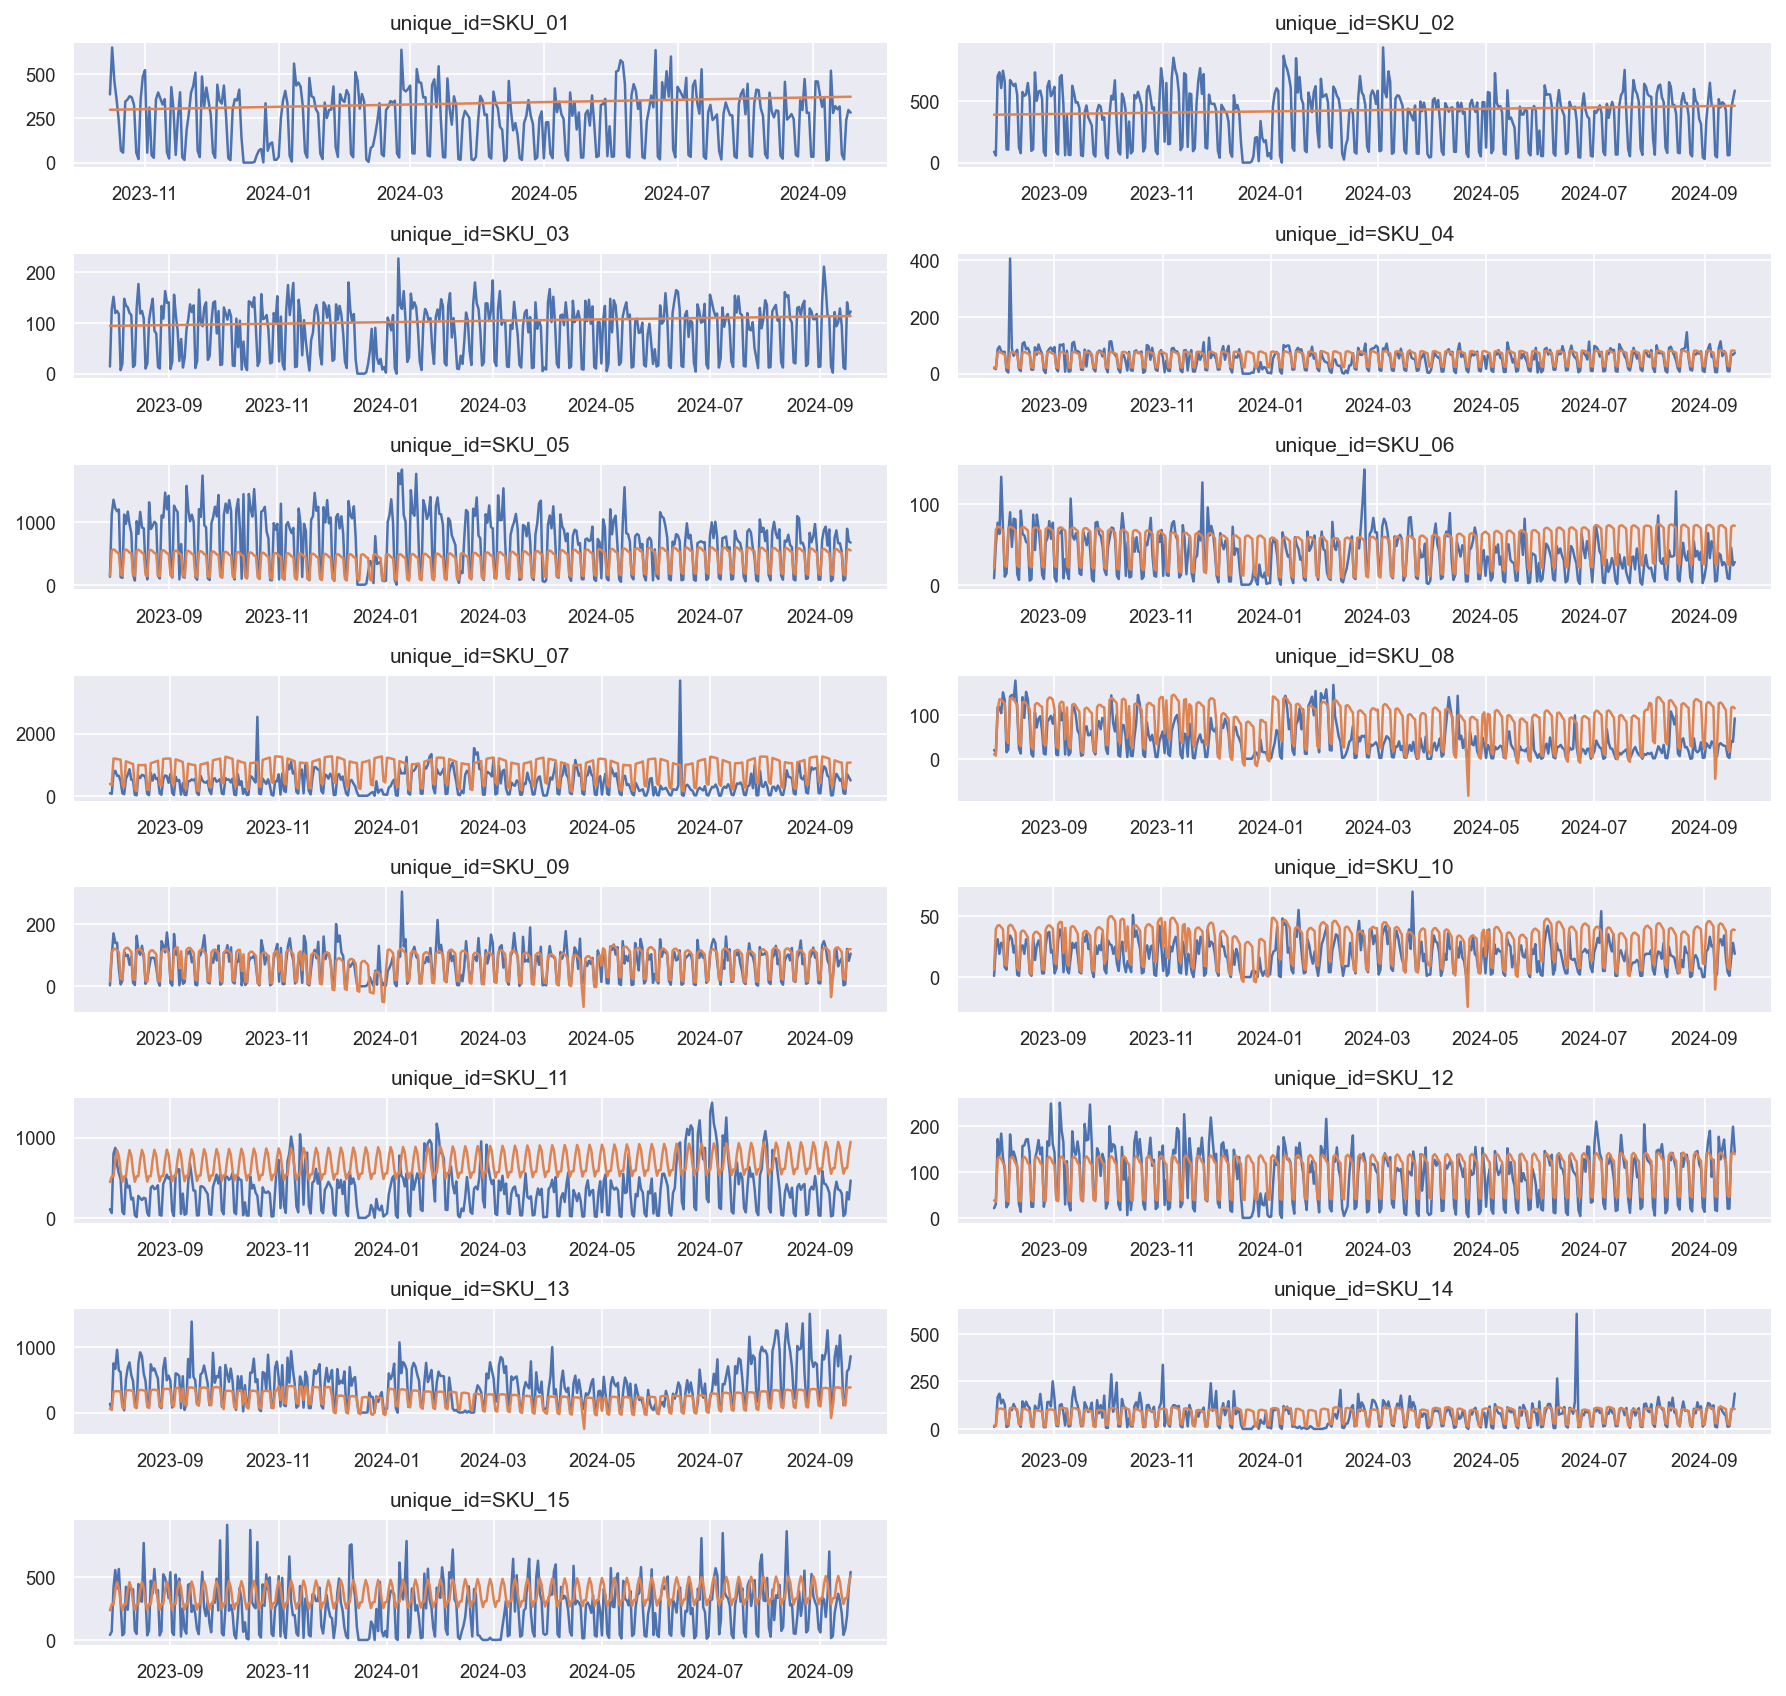

In [15]:
fig = plot_time_series(df=mlr_fcst, data_cols=['y','y_pred'])

In [16]:
mlr_eval = Evaluation(mlr_fcst)
mlr_eval.summary()
mlr_eval.save_evaluation(EVAL_PATH, 'Reg. Linear Multipla [+Lags +Fourier +Lasso]')
mlr_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,153.29,36639.01,191.41,-0.30
SKU_02,192.06,56224.93,237.12,-0.07
SKU_03,44.95,3176.19,56.36,-0.13
SKU_04,17.97,772.75,27.80,0.47
SKU_05,340.46,200403.76,447.66,0.06
SKU_06,19.61,625.49,25.01,0.11
SKU_07,498.65,339213.90,582.42,-1.37
SKU_08,47.34,3276.90,57.24,-0.95
SKU_09,22.77,977.07,31.26,0.63
SKU_10,12.79,234.28,15.31,-0.47


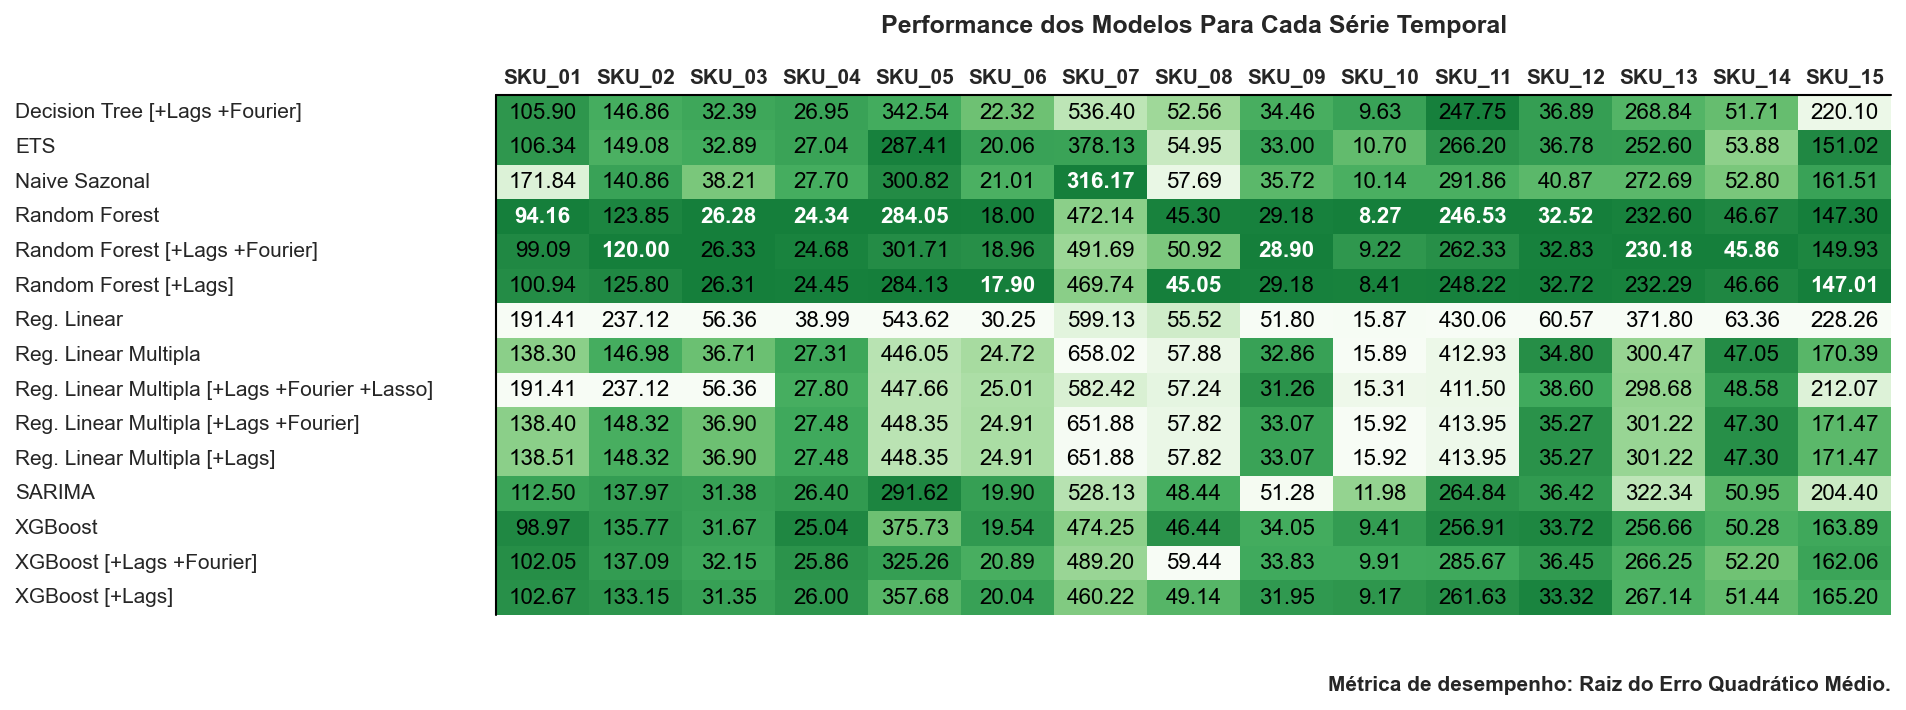

In [17]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].sort_values().unique()
metrics = metrics.pivot_table('rmse','unique_id','model')[order]

fig = plot_metrics(metrics, figsize=(12, 4.5))